<a href="https://colab.research.google.com/github/elson-terakado/adult-census-income-classification/blob/main/Adult_Census_Income_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adult Census Income | Classification**


<a>
  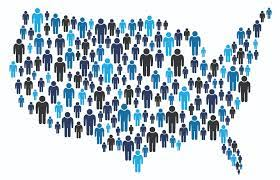
</a>

Output: predict if the income is greater or lower than 50K

In [ ]:
'''

* Dúvidas:

- vale fazer one-hot encoding para categorias que bastante concentração de algum income? RESP.: mais comum one-hot encoding, ordinal encoding...label encoding, binary encoding é mais difícil; target encoding tomar cuidado com overfitting (para isso dá para fazer cross-validation); frequency encoding é difícil de usar também
- ideias de feature engineering? o que extrair do EDA? RESP.: por exemplo tem SHAP para entender importância das variáveis...também existem métodos de escolha de variáveis (forward, backward e Exhaustive Feature Selection)
- como tratar imbalanced data? RESP.: oversampling, undersampling, class weighting; mas os modelos ensemble costumam já tratar isso

- tratamento de erro para quando não tiver coluna para dropar, ignorar


* Sugestões Feature Engineering:

Renda de Capital Total: Combinar capital-gain e capital-loss em uma única variável subtraindo a perda de capital do ganho de capital.
Educação por Idade: Divisão de education-num pela idade para saber o quão "educada" uma pessoa é para sua idade.
Índices Socio-Econômicos (PIB per Capita, IDH): Trazer uma variável numérica pode ser melhor para ver a distância de desenvolvimento dos países. Mas também pode ser criada uma variável categórica (1º Mundo, 2º Mundo, 3º Mundo)
workclass / occupation: is there a trustable resource to bring average wage, for example?

'''

In [ ]:
#!pip uninstall shap
!pip install shap

#pip cache purge (pra apagar cache de todos os seus pacotes)
#!pip cache remove shap #(apaga só do shap)

In [ ]:
!pip install requests beautifulsoup4

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import shap

import requests
from bs4 import BeautifulSoup

from google.colab import drive
drive.mount('/content/drive')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score

Mounted at /content/drive


In [ ]:
filename = '/content/drive/MyDrive/Data_Science/adult-all.csv'
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education.num",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
    "native.country",
    "income"
]

df = pd.read_csv(filename, header=None, names=columns)
df.head(2)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [ ]:
# Checking if it's an imbalanced data
count = df['income'].value_counts()
proportion = df['income'].value_counts(normalize=True)

result = pd.DataFrame({'Count': count, 'Proportion': proportion})

print(result)

       Count  Proportion
<=50K  37155    0.760718
>50K   11687    0.239282


# **Data Cleaning**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education.num   48842 non-null  int64 
 5   marital.status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital.gain    48842 non-null  int64 
 11  capital.loss    48842 non-null  int64 
 12  hours.per.week  48842 non-null  int64 
 13  native.country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
df = df.drop('fnlwgt', axis=1)
#df = df.drop('education', axis=1)
df.head(2)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [ ]:
df = df.drop_duplicates()
df.shape

(42468, 14)

In [ ]:
df.isnull().sum()

age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [ ]:
df.isna().sum()

age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

# **Splitting the dataset**

In [ ]:
split_ratio = 0.8
train_df = df.sample(frac=split_ratio, random_state=42)
test_df = df.drop(train_df.index)

In [ ]:
# Transform income into numeric
train_df['income'].replace('<=50K', 0, inplace=True)
train_df['income'].replace('>50K', 1, inplace=True)

test_df['income'].replace('<=50K', 0, inplace=True)
test_df['income'].replace('>50K', 1, inplace=True)

# **EDA & Data Preparation**



## Checklist

In [ ]:
'''
 0   age             48842 non-null  int64  -------------------- OK (one-hot encoding)
 1   workclass       48842 non-null  object -------------------- OK (one-hot encoding)
 2   education       48842 non-null  object -------------------- OK (deleted)
 3   education.num   48842 non-null  int64  -------------------- OK (ordinal encoding)
 4   marital.status  48842 non-null  object -------------------- OK (one-hot encoding)
 5   occupation      48842 non-null  object -------------------- OK (one-hot encoding)
 6   relationship    48842 non-null  object -------------------- OK (one-hot encoding)
 7   race            48842 non-null  object -------------------- OK (one-hot encoding)
 8   sex             48842 non-null  object -------------------- OK (one-hot encoding)
 9   capital.gain    48842 non-null  int64  --------------------
 10  capital.loss    48842 non-null  int64  --------------------
 11  hours.per.week  48842 non-null  int64  -------------------- OK (one-hot encoding)
 12  native.country  48842 non-null  object -------------------- OK (one-hot encoding of continent)
 13  income          48842 non-null  int64  -------------------- OK (income)
'''

## Intro

In [ ]:
df.describe()

,age,education.num,capital.gain,capital.loss,hours.per.week,income
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,10.078089,1079.067626,87.502314,40.422382,0.239282
std,13.710510,2.570973,7452.019058,403.004552,12.391444,0.426649
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


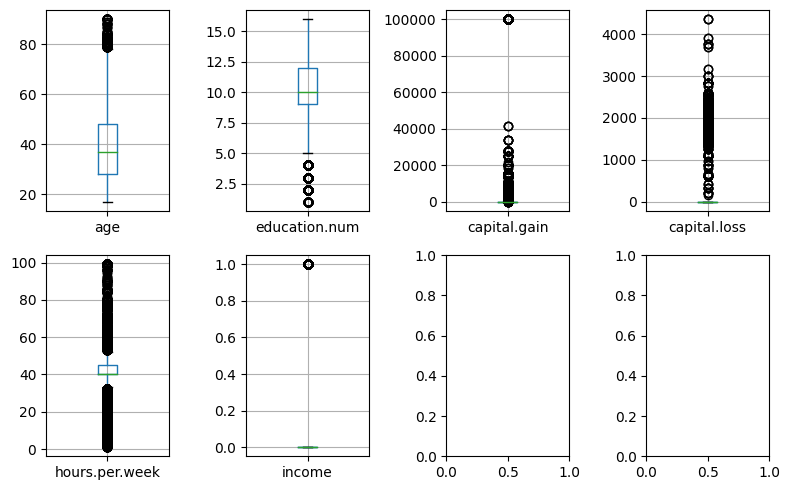

In [ ]:
# Distribution of continuous variables

continuous_vars =  [
    'age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week', 'income'
    ]
fig, axes = plt.subplots(2,4) # create figure and axes

for i, el in enumerate(list(df[continuous_vars].columns.values)):
  a = df.boxplot(el, ax=axes.flatten()[i], fontsize='medium')

fig.set_size_inches(8, 5)
plt.tight_layout()

plt.show()

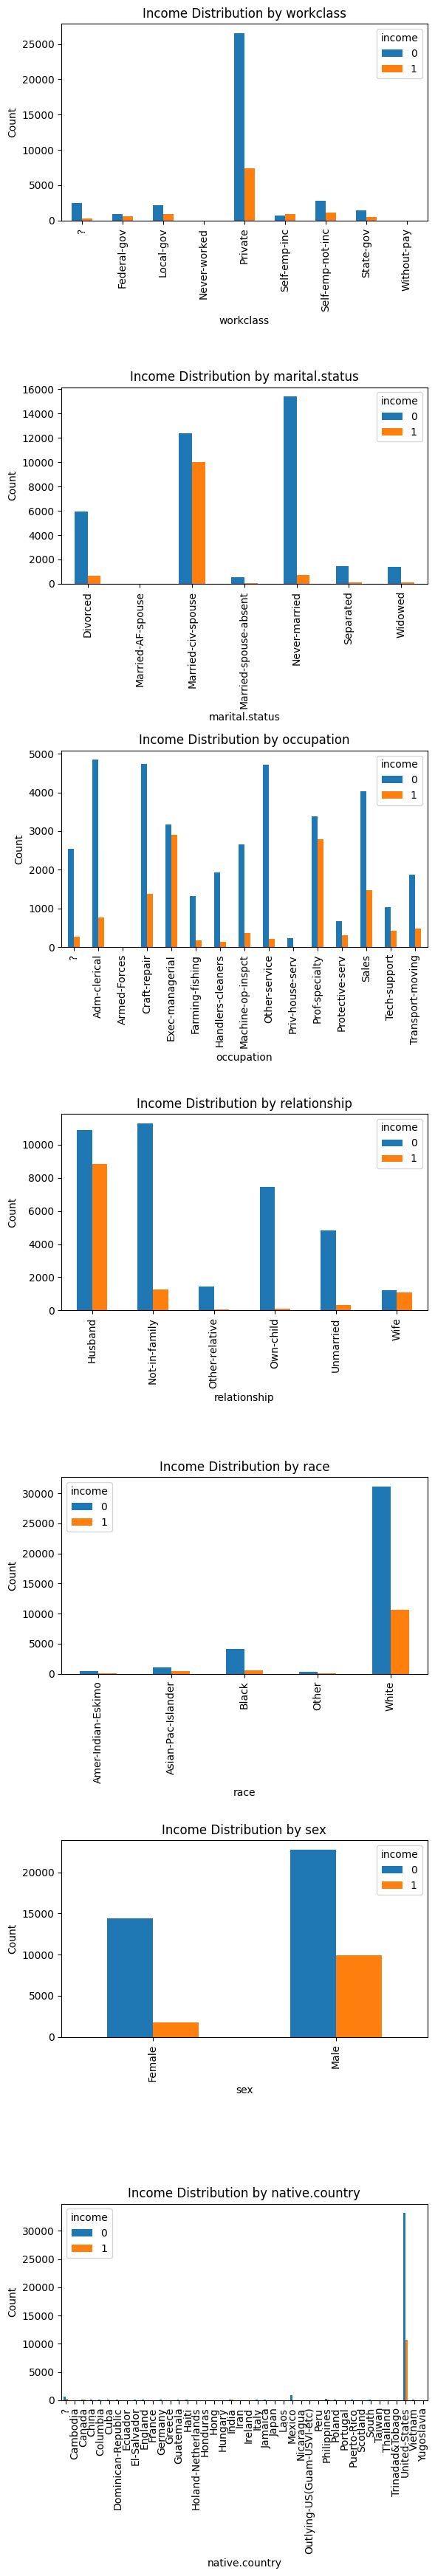

In [ ]:
continuous_vars =  ['workclass','marital.status','occupation','relationship','race','sex','native.country']

# Create subplots
fig, axs = plt.subplots(len(continuous_vars), figsize=(6, len(continuous_vars) * 5))

# Iterate over the categorical variables
for i, cat_var in enumerate(continuous_vars):
    # Group the data based on the categorical variable and calculate the count of each category for the binary variable
    grouped_data = df.groupby([cat_var, 'income']).size().unstack()

    # Plot the bar chart
    ax = axs[i]
    grouped_data.plot(kind='bar', stacked=False, ax=ax)

    # Set chart labels and title
    ax.set_xlabel(cat_var)
    ax.set_ylabel('Count')
    ax.set_title(f'Income Distribution by {cat_var}')

# Adjust the layout
plt.tight_layout()

# Show the chart
plt.show()

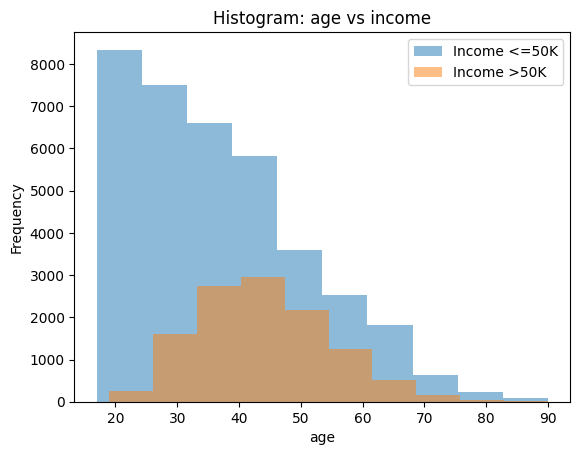

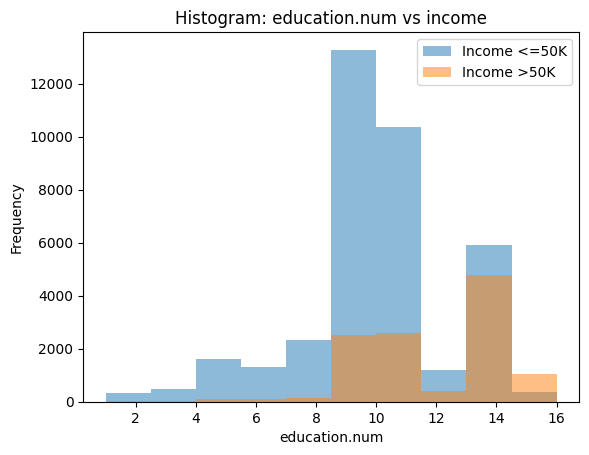

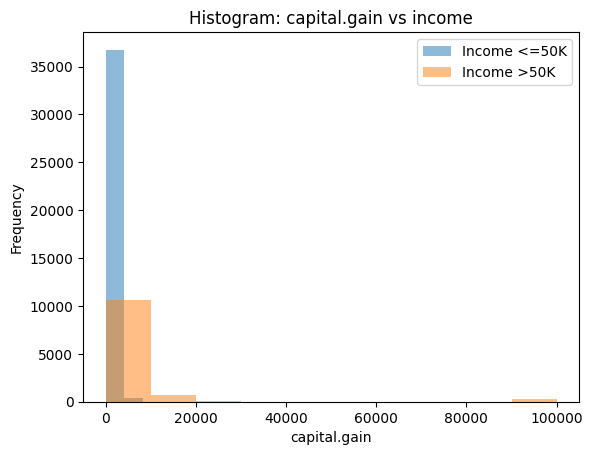

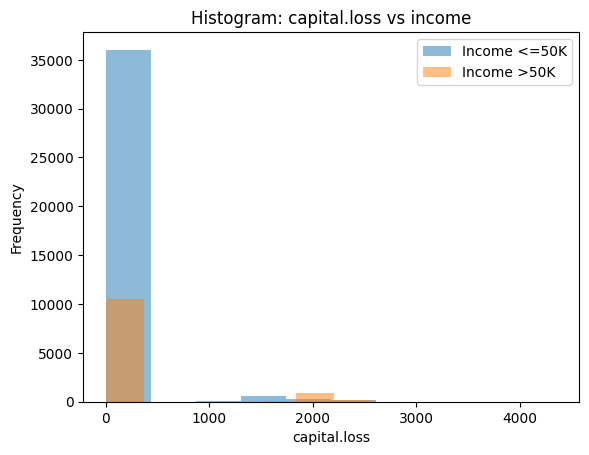

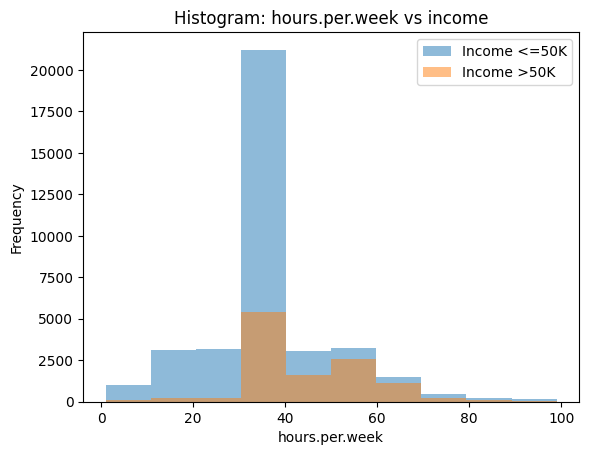

In [ ]:
# Define the list of columns and the income variable
columns = ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
income_column = 'income'

# Create histograms for each column
for column in columns:
    # Separate the data based on income categories
    income_0 = df[df[income_column] == 0]
    income_1 = df[df[income_column] == 1]

    # Plot the histograms
    plt.hist(income_0[column], alpha=0.5, label='Income <=50K')
    plt.hist(income_1[column], alpha=0.5, label='Income >50K')

    # Set the plot labels and title
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f"Histogram: {column} vs {income_column}")

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()

In [ ]:
df.head(2)

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K


In [ ]:
df.corr()

<ipython-input-9-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,age,education.num,capital.gain,capital.loss,hours.per.week,income
age,1.000000,0.030940,0.077229,0.056944,0.071558,0.230369
education.num,0.030940,1.000000,0.125146,0.080972,0.143689,0.332613
capital.gain,0.077229,0.125146,1.000000,-0.031441,0.082157,0.223013
capital.loss,0.056944,0.080972,-0.031441,1.000000,0.054467,0.147554
hours.per.week,0.071558,0.143689,0.082157,0.054467,1.000000,0.227687
income,0.230369,0.332613,0.223013,0.147554,0.227687,1.000000


## Age

In [ ]:
df['age'].describe()

count    48842.000000
mean        38.643585
std         13.710510
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

In [ ]:
'''
Infants (0-1 year), Toddlers (1-2 years), Toddlers (2-3 years), Preschoolers (3-5 years), Middle Childhood (6-8 years),
Middle Childhood (9-11 years), Young Teens (12-14 years), Teenagers (15-17 years)
young or early adulthood (approximately aged 20–39), middle adulthood (40–59), and old age (60+). Old age is typically divided into
the periods of young old (60–75) and old old (75 and up)
'''

def transform_to_categorical_age(df, column_name):
    # Define the age ranges and corresponding labels
    age_ranges = [(0, 17), (20, 39), (40, 59), (60, 74), (75, float('inf'))]
    age_labels = ['child_teenager', 'young_adulthodd', 'middle_adulthood', 'young_old', 'old_old']
    #age_labels = [1, 2, 3, 4, 5]

    # Apply the transformation and substitution
    df['age.category'] = pd.cut(df[column_name], bins=[0, 17, 39, 59, 74, float('inf')], labels=age_labels, include_lowest=True)

    return df

In [ ]:
train_df = transform_to_categorical_age(train_df, 'age')
test_df = transform_to_categorical_age(test_df, 'age')

In [ ]:
train_df = pd.get_dummies(train_df, columns=['age.category'])
test_df = pd.get_dummies(test_df, columns=['age.category'])

In [ ]:
train_df = train_df.drop('age', axis=1)
test_df = test_df.drop('age', axis=1)

## Workclass

In [ ]:
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [ ]:
train_df = pd.get_dummies(train_df, columns=['workclass'])
test_df = pd.get_dummies(test_df, columns=['workclass'])

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33974 entries, 40654 to 38123
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   education.num               33974 non-null  int64   
 1   marital.status              33974 non-null  object  
 2   occupation                  33974 non-null  object  
 3   relationship                33974 non-null  object  
 4   capital.gain                33974 non-null  int64   
 5   capital.loss                33974 non-null  int64   
 6   income                      33974 non-null  int64   
 7   age.encoded                 33974 non-null  category
 8   continent_Asia              33974 non-null  uint8   
 9   continent_Europe            33974 non-null  uint8   
 10  continent_North America     33974 non-null  uint8   
 11  continent_Oceania           33974 non-null  uint8   
 12  continent_South America     33974 non-null  uint8   
 13  sex_Female  

In [ ]:
train_df = train_df.drop('workclass_?', axis=1)
test_df = test_df.drop('workclass_?', axis=1)

## Education & Education.num

In [ ]:
unique_values = df.groupby('education')['education.num'].unique()
unique_values.sort_values()

education
Preschool        [1]
1st-4th          [2]
5th-6th          [3]
7th-8th          [4]
9th              [5]
10th             [6]
11th             [7]
12th             [8]
HS-grad          [9]
Some-college    [10]
Assoc-voc       [11]
Assoc-acdm      [12]
Bachelors       [13]
Masters         [14]
Prof-school     [15]
Doctorate       [16]
Name: education.num, dtype: object

In [ ]:
train_df = train_df.drop('education', axis=1)
test_df = test_df.drop('education', axis=1)

## Marital.status

In [ ]:
train_df = pd.get_dummies(train_df, columns=['marital.status'])
test_df = pd.get_dummies(test_df, columns=['marital.status'])

In [ ]:
#train_df = train_df.drop('workclass_?', axis=1)
#test_df = test_df.drop('workclass_?', axis=1)

KeyError: ignored

## Occupation

In [ ]:
df['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [ ]:
train_df = pd.get_dummies(train_df, columns=['occupation'])
test_df = pd.get_dummies(test_df, columns=['occupation'])

In [ ]:
train_df = train_df.drop('occupation_?', axis=1)
test_df = test_df.drop('occupation_?', axis=1)

## Relationship

In [ ]:
train_df = pd.get_dummies(train_df, columns=['relationship'])
test_df = pd.get_dummies(test_df, columns=['relationship'])

## Race

In [ ]:
df['race'].value_counts()

White                 35541
Black                  4536
Asian-Pac-Islander     1515
Amer-Indian-Eskimo      470
Other                   406
Name: race, dtype: int64

In [ ]:
train_df = pd.get_dummies(train_df, columns=['race'])
test_df = pd.get_dummies(test_df, columns=['race'])

## Sex

In [ ]:
train_df = pd.get_dummies(train_df, columns=['sex'])
test_df = pd.get_dummies(test_df, columns=['sex'])

## Capital.gain

In [ ]:
'''
Definition: Capital gain is the profit one earns on the sale of an asset like stocks, bonds or real estate. It results in capital gain when the
selling price of an asset exceeds its purchase price. It is the difference between the selling price (higher) and cost price (lower) of the asset.
'''

## Capital.loss

In [ ]:
'''
A capital loss is the loss incurred when a capital asset, such as an investment or real estate, decreases in value. This loss is not realized
until the asset is sold for a price that is lower than the original purchase price.
'''

## Hours.per.week

In [ ]:
'''
Full-time employment is 35 hours or more per week.
Part-time employment is 1–34 hours per week.
Over-time: working more than 55 hours a week
'''

In [ ]:
def transform_to_categorical_hpw(df, column_name):
    # Define the age ranges and corresponding labels
    hpw_ranges = [(0, 34), (35, 55), (56, float('inf'))]
    hpw_labels = ['Part-time', 'Full-time', 'Over-time']

    # Apply the transformation and substitution
    df['hpw.category'] = pd.cut(df[column_name], bins=[0, 34, 55, float('inf')], labels=hpw_labels, include_lowest=True)

    return df

In [ ]:
train_df = transform_to_categorical_hpw(train_df, 'hours.per.week')
test_df = transform_to_categorical_hpw(test_df, 'hours.per.week')

In [ ]:
train_df = pd.get_dummies(train_df, columns=['hpw.category'])
test_df = pd.get_dummies(test_df, columns=['hpw.category'])

In [ ]:
train_df = train_df.drop('hours.per.week', axis=1)
test_df = test_df.drop('hours.per.week', axis=1)

## Native.country / continent

In [ ]:
df['native.country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [ ]:
country_to_continent = {
    'United-States': 'North America',
    'Cuba': 'North America',
    'Jamaica': 'North America',
    'India': 'Asia',
    '?': 'Unknown',
    'Mexico': 'North America',
    'South': 'Asia',
    'Puerto-Rico': 'North America',
    'Honduras': 'North America',
    'England': 'Europe',
    'Canada': 'North America',
    'Germany': 'Europe',
    'Iran': 'Asia',
    'Philippines': 'Asia',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Columbia': 'South America',
    'Cambodia': 'Asia',
    'Thailand': 'Asia',
    'Ecuador': 'South America',
    'Laos': 'Asia',
    'Taiwan': 'Asia',
    'Haiti': 'North America',
    'Portugal': 'Europe',
    'Dominican-Republic': 'North America',
    'El-Salvador': 'North America',
    'France': 'Europe',
    'Guatemala': 'North America',
    'China': 'Asia',
    'Japan': 'Asia',
    'Yugoslavia': 'Europe',
    'Peru': 'South America',
    'Outlying-US(Guam-USVI-etc)': 'Oceania',
    'Scotland': 'Europe',
    'Trinadad&Tobago': 'North America',
    'Greece': 'Europe',
    'Nicaragua': 'North America',
    'Vietnam': 'Asia',
    'Hong': 'Asia',
    'Ireland': 'Europe',
    'Hungary': 'Europe',
    'Holand-Netherlands': 'Europe'
}

In [ ]:
train_df['continent'] = train_df['native.country'].map(country_to_continent)
test_df['continent'] = test_df['native.country'].map(country_to_continent)

In [ ]:
train_df = pd.get_dummies(train_df, columns=['continent'])
test_df = pd.get_dummies(test_df, columns=['continent'])

In [ ]:
train_df = train_df.drop(['native.country', 'continent_Unknown'], axis=1)
test_df = test_df.drop(['native.country', 'continent_Unknown'], axis=1)

## New Variables - per capita income

In [ ]:
# web scrapping

url = "https://www.nationsonline.org/oneworld/human_development.htm"
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
tables = soup.find_all('table')

data = []
headers = []

# Find the table with the appropriate structure
for table in tables:
    rows = table.find_all('tr')
    if len(rows) > 1:
        headers = [header.text.strip() for header in rows[0].find_all('td')]
        data = [[cell.text.strip() for cell in row.find_all('td')] for row in rows[1:]]
        break

Empty DataFrame
Columns: []
Index: []


In [ ]:
df_gdp = pd.DataFrame(data, columns=headers)

In [ ]:
df_gdp.head(2)

""


In [ ]:
df_gdp = df_gdp.drop(['#', 'GDP (nominal) per capita (2017)', 'vs. World PPP  GDP per capita ($17,100)'], axis=1)

In [ ]:
df_gdp.rename(columns={'GDP (PPP)  per capita  (2017)': 'gdp_per_capita'}, inplace=True)

In [ ]:
df_gdp

,Country,gdp_per_capita
0,Qatar,"$128,647"
1,Macao,"$115,367"
2,Luxembourg,"$107,641"
3,Singapore,"$94,105"
4,Brunei,"$79,003"
...,...,...
183,Burundi,$735
184,Central African Republic,$727
185,Guam,N.A.
186,Cuba,N.A.


In [ ]:
df_gdp = df_gdp.replace(to_replace='N.A.', value='0')

In [ ]:
df_gdp = df_gdp.replace(to_replace='$', value='')

In [ ]:
df_gdp['gdp_per_capita'] = df_gdp['gdp_per_capita'].str.replace('$', '').str.replace(',', '')
df_gdp['gdp_per_capita'] = df_gdp['gdp_per_capita'].astype(int)

<ipython-input-37-5a0b0ae0df33>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_gdp['gdp_per_capita'] = df_gdp['gdp_per_capita'].str.replace('$', '').str.replace(',', '')


In [ ]:
df_gdp.sort_values(by='Country', ascending=True)

,Country,gdp_per_capita
167,Afghanistan,1976
96,Albania,12943
83,Algeria,15293
187,American Samoa,0
126,Angola,6658
...,...,...
153,Vanuatu,3215
125,Vietnam,6790
159,Yemen,2606
141,Zambia,4033


In [ ]:
df_gdp.to_excel('teste.xlsx', index=False)

In [ ]:
filtered_df = df_gdp[df_gdp['Country'] == 'Puerto Rico']
print(filtered_df)

             Country gdp_per_capita
Country  Puerto Rico    Puerto Rico


In [ ]:
df['native.country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [ ]:
train_df['native.country'] = train_df['native.country'].str.replace('-', ' ')
test_df['native.country'] = test_df['native.country'].str.replace('-', ' ')

In [ ]:
train_df['gdp_per_capita'] = train_df['native.country'].map(df_gdp.set_index('Country')['gdp_per_capita'])
test_df['gdp_per_capita'] = test_df['native.country'].map(df_gdp.set_index('Country')['gdp_per_capita'])

In [ ]:
train_df['gdp_per_capita'] = train_df['gdp_per_capita'].replace('Puerto Rico', 0)
test_df['gdp_per_capita'] = test_df['gdp_per_capita'].replace('Puerto Rico', 0)

In [ ]:
#train_df['gdp_per_capita'] = train_df['gdp_per_capita'].astype(int)
#test_df['gdp_per_capita'] = test_df['gdp_per_capita'].astype(int)

In [ ]:
train_df['gdp_per_capita'].unique()

array([59928.,     0., 18656.,    nan,  8361., 52556., 16842., 44033.,
        7166., 42067., 46510.,  8168., 13463.,  6790.,  4997.,  9066.,
        1819., 76745., 40924., 16064.,  8023., 17910., 32554., 20885.,
       28799., 29924.,  5855., 11612.,  7038., 28583.,  4018.])

In [ ]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [ ]:
test_df['gdp_per_capita'].unique()

array([59928.,     0., 46510.,  1819., 29924.,  9066., 18656., 52556.,
        8168.,  7166., 42067., 40924., 16842.,  8361., 28583., 16064.,
       20885., 44033.,  6790., 76745., 11612.,  8023., 13463.,  7038.,
       17910., 32554.,  4018.,  5855., 28799.,  4997.])

## New Variables - HDI

In [ ]:
url = "https://www.theglobaleconomy.com/rankings/human_development/"
response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')

data = []
headers = []

for row in table.find_all('tr'):
    if not headers:
        headers = [header.text for header in row.find_all('th')]
    else:
        row_data = [cell.text for cell in row.find_all('td')]
        data.append(row_data)

df = pd.DataFrame(data, columns=headers)

    \r\n\t\t\t\t\t\t\t\t\tCountries\r\n\t\t\t\t\t\t\t\t  \
0                                    \nSwitzerland\n\n    
1                                         \nNorway\n\n    
2                                        \nIceland\n\n    
3                                      \nHong Kong\n\n    
4                                      \nAustralia\n\n    
..                                                 ...    
179                                      \nBurundi\n\n    
180                                \nC.A. Republic\n\n    
181                                        \nNiger\n\n    
182                                         \nChad\n\n    
183                                 \nSouth Africa\n\n    

    \r\n\t\t\t\t\t\t\t\t\tHuman development, 2021\r\n\t\t\t\t\t\t\t\t  \
0                            0.962\r\n\t\t\t\t\t\t\t\t                  
1                            0.961\r\n\t\t\t\t\t\t\t\t                  
2                            0.959\r\n\t\t\t\t\t\t\t\t                  

# **Feature Engineering** - IGNORAR (modo simplista de label encoder)

In [ ]:
# continuous_vars = ['age','education','education.num','capital.gain','capital.loss','hours.per.week']

In [ ]:
# Transform income into numeric
train_df['income'].replace('<=50K', 0, inplace=True)
train_df['income'].replace('>50K', 1, inplace=True)

test_df['income'].replace('<=50K', 0, inplace=True)
test_df['income'].replace('>50K', 1, inplace=True)

In [ ]:
categorical_vars =  ['workclass','marital.status','occupation','relationship','race','sex','native.country']

# Create a dictionary to store the label encoders for each variable
label_encoders = {}

for variable in categorical_vars:
    label_encoder = LabelEncoder() # Create a label encoder object
    encoded_variable = label_encoder.fit_transform(train_df[variable]) # Fit the label encoder to the variable and transform the variable
    train_df[variable] = encoded_variable # Update the original dataframe with the encoded variable
    label_encoders[variable] = label_encoder # Store the label encoder object in the dictionary

for variable in categorical_vars:
    label_encoder = LabelEncoder() # Create a label encoder object
    encoded_variable = label_encoder.fit_transform(test_df[variable]) # Fit the label encoder to the variable and transform the variable
    test_df[variable] = encoded_variable # Update the original dataframe with the encoded variable
    label_encoders[variable] = label_encoder # Store the label encoder object in the dictionary

# **Splitting the dataset**

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33974 entries, 40654 to 38123
Data columns (total 57 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   education.num                         33974 non-null  int64
 1   income                                33974 non-null  int64
 2   age.category_child_teenager           33974 non-null  uint8
 3   age.category_young_adulthodd          33974 non-null  uint8
 4   age.category_middle_adulthood         33974 non-null  uint8
 5   age.category_young_old                33974 non-null  uint8
 6   age.category_old_old                  33974 non-null  uint8
 7   workclass_Federal-gov                 33974 non-null  uint8
 8   workclass_Local-gov                   33974 non-null  uint8
 9   workclass_Never-worked                33974 non-null  uint8
 10  workclass_Private                     33974 non-null  uint8
 11  workclass_Self-emp-inc               

In [ ]:
X_train = train_df.drop('income', axis=1)
y_train = train_df['income']

X_test = test_df.drop('income', axis=1)
y_test = test_df['income']

# **Model building & Evaluation**

In [ ]:
train_df = train_df.drop(['capital.gain', 'capital.loss'], axis=1)
test_df = test_df.drop(['capital.gain', 'capital.loss'], axis=1)

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machines (SVM)': SVC(),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [ ]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # X_train and y_train represent your training data
    y_pred = model.predict(X_test)  # X_test represents your test data
    accuracy = accuracy_score(y_test, y_pred)  # y_test represents the true values of the target variable
    results[name] = accuracy

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
for name, accuracy in results.items():
    print(f"{name}: Accuracy = {accuracy}")

Logistic Regression: Accuracy = 0.8457734871674123
Decision Tree: Accuracy = 0.8478926300918296
Random Forest: Accuracy = 0.8535436778902755
Support Vector Machines (SVM): Accuracy = 0.7999764539675065
K-Nearest Neighbors (KNN): Accuracy = 0.8567223922769014
Naive Bayes: Accuracy = 0.8030374381916647


In [ ]:
# performance making the label encoder for every variable
'''
Logistic Regression: Accuracy = 0.8036445536445537
Decision Tree: Accuracy = 0.8251433251433251
Random Forest: Accuracy = 0.8505323505323505
Support Vector Machines (SVM): Accuracy = 0.8025184275184275
K-Nearest Neighbors (KNN): Accuracy = 0.8434684684684685
Naive Bayes: Accuracy = 0.797911547911548
'''

# **Treatment for imbalanced class**

# **SHAP**

In [ ]:
# Create Random Forest Classifier
rf = RandomForestClassifier()

# Train the model using the training sets
rf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = rf.predict(X_test)

NameError: ignored

In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.853072757240405


In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

In [ ]:
# Create summary_plot
shap.summary_plot(shap_values, X_test)